# Steam Marketplace Sentiment Prediction

Matt Calcaterra<br>
Mohammad Awad<br>

## Purpose
The intent of this project was to conduct an exploration of data and reviews for games in the Steam marketplace. After our exploration has been completed, we will attempt to build a model which can predict the sentiment of customers towards a new game which will be released. 


## Data acquisition
Our data comes from two main sources: webscraping steam reviews and the steamspy API for game information

Since both of these datasets are rather larger (specifically the reviews dataframe), they were collected in a different notebook and then saved to a csv file.

### Steamspy API

### Steam Reviews

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Import statsmodels for regression
import statsmodels.api as sm
from statsmodels.formula.api import ols


# Import scikit-learn tools for preprocessing and models
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
)
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MultiLabelBinarizer,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR

# Import NLTK tools for sentiment analysis
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download("all")

import warnings

warnings.filterwarnings("ignore")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\abc.zip.
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers\averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping grammars\basque_grammars.zip.
[nltk_data]   

## Set up formatting for visuals

In [2]:
sns.set_style("darkgrid")
sns.set_palette("Set2")

## Import Data

In [85]:
# Readomg Steam Review Dataset
reviews_df = pd.read_csv("data/steam_review_data1.csv.gz", compression="gzip")

In [169]:
reviews_df.shape

(1336828, 18)

In [170]:
# Reading Steam Sentiment Analysis Dataset
sent_df = pd.read_csv("data/steam_review_sentiment.csv.gz", compression="gzip")

In [171]:
# Reading Steam Game Dataset
games_df = pd.read_csv("data/steamspy_data.csv")

In [172]:
test = "casual"
test.split(", ")

['casual']

In [173]:
# Displaying a random sample of 20 genres from the games_df DataFrame to see how the genre column is formatted
games_df.genre.sample(20)

55805                      Adventure, Indie
566                                Strategy
8146                          Action, Indie
33108                         Action, Indie
26361              Action, Adventure, Indie
4812              Casual, Indie, Simulation
43835                            Simulation
71                                   Action
50822    Indie, RPG, Strategy, Early Access
31121              Action, Adventure, Indie
52465              Adventure, Casual, Indie
4285            Action, Adventure, Strategy
35200               Casual, Indie, Strategy
3561                        Indie, Strategy
54605                                Casual
59216                                   NaN
36780                      Adventure, Indie
4257                         Action, Racing
40829                         Action, Indie
2197                          Action, Indie
Name: genre, dtype: object

In [174]:
# Displaying the columns and rows of the games_df DataFrame to get a better understanding of the data
games_df.shape

(63968, 20)

In [175]:
# Displaying the first few rows of the games_df DataFrame to get a quick overview
games_df.head()

,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,languages,genre,ccu,tags
0,10,Counter-Strike,Valve,Valve,NaN,193046,4940,0,"10,000,000 .. 20,000,000",8486,178,196,128,999.0,999.0,0.0,"English, French, German, Italian, Spanish - Sp...",Action,16360,"{'Action': 5379, 'FPS': 4801, 'Multiplayer': 3..."
1,20,Team Fortress Classic,Valve,Valve,NaN,5412,895,0,"5,000,000 .. 10,000,000",551,58,14,58,499.0,499.0,0.0,"English, French, German, Italian, Spanish - Sp...",Action,87,"{'Action': 745, 'FPS': 306, 'Multiplayer': 257..."
2,30,Day of Defeat,Valve,Valve,NaN,5003,556,0,"5,000,000 .. 10,000,000",421,73,23,73,499.0,499.0,0.0,"English, French, German, Italian, Spanish - Spain",Action,122,"{'FPS': 787, 'World War II': 248, 'Multiplayer..."
3,40,Deathmatch Classic,Valve,Valve,NaN,1852,412,0,"5,000,000 .. 10,000,000",318,0,7,0,499.0,499.0,0.0,"English, French, German, Italian, Spanish - Sp...",Action,7,"{'Action': 629, 'FPS': 139, 'Classic': 107, 'M..."
4,50,Half-Life: Opposing Force,Gearbox Software,Valve,NaN,13262,662,0,"5,000,000 .. 10,000,000",676,0,150,0,499.0,499.0,0.0,"English, French, German, Korean",Action,122,"{'FPS': 881, 'Action': 322, 'Classic': 251, 'S..."


## Sentiment analysis

We will run sentiment analysis to access sentiment components for each review. Due to the size of our reviews dataset the sentiment analysis writes to a .csv file. This file will be used for further analysis and the code below has been commented out.

In [176]:
# def preprocess_text(text):
#     # Tokenize the text
#     tokens = word_tokenize(text.lower())

#     # Remove stop words
#     filtered_tokens = [
#         token for token in tokens if token not in stopwords.words("english")
#     ]

#     # Lemmatize the tokens
#     lemmatizer = WordNetLemmatizer()
#     lemmatized_tokens = [
#         lemmatizer.lemmatize(token) for token in filtered_tokens
#     ]

#     # Join the tokens back into a string
#     processed_text = " ".join(lemmatized_tokens)
#     return processed_text

In [177]:
# # initialize NLTK sentiment analyzer
# analyzer = SentimentIntensityAnalyzer()


# # create get_sentiment function
# def get_sentiment(text):
#     # get sentiment scores for the review text
#     scores = analyzer.polarity_scores(text)

#     return scores

We have created two functions which we will use to extract the sentiment values from each review in our reviews dataframe. The first functinon, preprocess_text, will clean the text of each review by removing punctuation, stop words, and converting all text to lowercase. The second function, sentiment_analysis, will run sentiment analysis on each review and return the sentiment components for each review.

The sentiment analysis components will be a dictionary containing positive, negative, neutral, and compound values for each review. The compound value is a normalized value between -1 and 1 which represents the overall sentiment of the review. A compound value of 1 represents a very positive review while a compound value of -1 represents a very negative review.

In [178]:
# review_df = review_df.dropna()

In [179]:
# review_df["review_processed"] = review_df["review"].apply(preprocess_text)
# review_df["sentiment"] = review_df["review_processed"].apply(get_sentiment)

In [180]:
# reduced_df = review_df[["appid", "sentiment"]]
# reduced_df.to_csv(
#     "data/steam_review_sentiment.csv.gz", index=False, compression="gzip"
# )

Due to the size of our dataset and the caliber of computing required, the results were written to csv and used for the remainder of the analysis.

### Reformatting
Our sentiment dataframe has a dictionary of sentiment scores for each review. The issue is that it is imported as a string, so we need to convert it to a dictionary.

In [181]:
# Displaying the 'sentiment' column from the sent_df DataFrame to see how the data is formatted
sent_df["sentiment"]

0          {'neg': 0.0, 'neu': 0.312, 'pos': 0.688, 'comp...
1          {'neg': 0.051, 'neu': 0.718, 'pos': 0.231, 'co...
2          {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3          {'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'comp...
4          {'neg': 0.015, 'neu': 0.607, 'pos': 0.378, 'co...
                                 ...                        
1336150    {'neg': 0.0, 'neu': 0.268, 'pos': 0.732, 'comp...
1336151    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
1336152    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1336153    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1336154    {'neg': 0.119, 'neu': 0.361, 'pos': 0.521, 'co...
Name: sentiment, Length: 1336155, dtype: object

We will run a functions which swaps single quotes for double quotes, and then converts the string to a dictionary using json.loads.

In [182]:
# Function to convert the 'sentiment' column from the sent_df DataFrame into a dictionary
def string_to_dict(dict_string):
    '''Convert a string representaion of a dictionary to a dictionary'''
    dict_string = dict_string.replace("'", '"') # Replace single quotes with double quotes
    return json.loads(dict_string)

In [183]:
# Applying the string_to_dict function to the 'sentiment' column from the sent_df DataFrame
sent_df["sentiment"] = sent_df["sentiment"].apply(string_to_dict)

In [184]:
# Expanding the sentiment dictionary into separate columns
expanded = pd.json_normalize(sent_df["sentiment"])

In [185]:
# Concatenating the expanded sentiment data back to the sentiment DataFrame
sent_df = pd.concat([sent_df, expanded], axis=1)

In [186]:
# Dropping the original sentiment column
sent_df = sent_df.drop(columns=["sentiment"])
sent_df.head()

,appid,neg,neu,pos,compound
0,10,0.000,0.312,0.688,0.7650
1,10,0.051,0.718,0.231,0.8519
2,10,0.000,1.000,0.000,0.0000
3,10,0.756,0.244,0.000,-0.4767
4,10,0.015,0.607,0.378,0.9769


In [187]:
# Group by average per game
sent_df = sent_df.groupby("appid").mean().reset_index()
sent_df.head()

,appid,neg,neu,pos,compound
0,10,0.10401,0.63499,0.26102,0.314473
1,20,0.08666,0.64698,0.23637,0.194547
2,30,0.12435,0.59344,0.25220,0.292516
3,40,0.12416,0.56693,0.28885,0.367227
4,50,0.07766,0.66268,0.23963,0.377009


In [188]:
# Renaming columns for clarity
sent_df = sent_df.rename(
    {
        "compound": "compound_sent",
        "neg": "neg_sent",
        "neu": "neu_sent",
        "pos": "pos_sent",
    },
    axis=1,
)

Now that we have renamed the columns we can merge is back into our game dataframe

In [189]:
# Merging the sentiment data with the games data
games_df = pd.merge(games_df, sent_df, on="appid")

In [190]:
games_df.head()

,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,...,initialprice,discount,languages,genre,ccu,tags,neg_sent,neu_sent,pos_sent,compound_sent
0,10,Counter-Strike,Valve,Valve,NaN,193046,4940,0,"10,000,000 .. 20,000,000",8486,...,999.0,0.0,"English, French, German, Italian, Spanish - Sp...",Action,16360,"{'Action': 5379, 'FPS': 4801, 'Multiplayer': 3...",0.10401,0.63499,0.26102,0.314473
1,20,Team Fortress Classic,Valve,Valve,NaN,5412,895,0,"5,000,000 .. 10,000,000",551,...,499.0,0.0,"English, French, German, Italian, Spanish - Sp...",Action,87,"{'Action': 745, 'FPS': 306, 'Multiplayer': 257...",0.08666,0.64698,0.23637,0.194547
2,30,Day of Defeat,Valve,Valve,NaN,5003,556,0,"5,000,000 .. 10,000,000",421,...,499.0,0.0,"English, French, German, Italian, Spanish - Spain",Action,122,"{'FPS': 787, 'World War II': 248, 'Multiplayer...",0.12435,0.59344,0.25220,0.292516
3,40,Deathmatch Classic,Valve,Valve,NaN,1852,412,0,"5,000,000 .. 10,000,000",318,...,499.0,0.0,"English, French, German, Italian, Spanish - Sp...",Action,7,"{'Action': 629, 'FPS': 139, 'Classic': 107, 'M...",0.12416,0.56693,0.28885,0.367227
4,50,Half-Life: Opposing Force,Gearbox Software,Valve,NaN,13262,662,0,"5,000,000 .. 10,000,000",676,...,499.0,0.0,"English, French, German, Korean",Action,122,"{'FPS': 881, 'Action': 322, 'Classic': 251, 'S...",0.07766,0.66268,0.23963,0.377009


# Addressing Null Values

## Steam Game Data

In [191]:
# Checking for null values in 'positive' and 'negative' columns in the games_df DataFrame
games_df[["positive", "negative"]].isna().sum()

positive    0
negative    0
dtype: int64

There are no null values in the positive and negative review counts, so we will create a new variable: `n_reviews` and then reduce our dataset to only those with more than 100 reviews.

Since there is little data for those with less than 100 reviews we will drop those rows in favor of a more robust dataset.

We want to drop the rows at this stage because it will make it easier to fill in the null values.

In [192]:
# Create a new variable for number of reviews
games_df["n_reviews"] = games_df["positive"] + games_df["negative"]

In [193]:
# Filter out games with less than 100 reviews
games_df = games_df[games_df["n_reviews"] >= 100]

In [194]:
# Checking number of columns and rows to compare to original games_df DataFrame
games_df.shape

(14642, 25)

In [195]:
# Checking for null values in the games_df DataFrame
games_df.isna().sum()

appid                  0
name                   1
developer             50
publisher             31
score_rank         14624
positive               0
negative               0
userscore              0
owners                 0
average_forever        0
average_2weeks         0
median_forever         0
median_2weeks          0
price                  2
initialprice           1
discount               1
languages              6
genre                 69
ccu                    0
tags                   0
neg_sent               0
neu_sent               0
pos_sent               0
compound_sent          0
n_reviews              0
dtype: int64

#### Price
- We will assume that if the price is null, then the game is free. We will fill in the null values with 0.

In [196]:
# Replacing null values in 'price' and 'initialprice' columns with 0 with assumption that null values mean the game is free
games_df[["price", "initialprice"]] = games_df[
    ["price", "initialprice"]
].fillna(0)

### Score_rank, userscore,  and discount

In [197]:
# Analyzing the distribution of values in the 'score_rank' column of games_df
games_df.score_rank.value_counts()

score_rank
99.0     8
100.0    5
98.0     4
97.0     1
Name: count, dtype: int64

In [116]:
# Analyzing the distribution of values in the 'userscore' column of games_df
games_df.userscore.value_counts()

userscore
0     14624
95        3
77        2
62        1
82        1
83        1
81        1
67        1
74        1
97        1
66        1
46        1
98        1
73        1
65        1
84        1
Name: count, dtype: int64

#### **Removing Redundant Columns from the DataFrame**

- **Analysis Rationale**: Upon analyzing the `score_rank` and `userscore` columns, we found that a significant proportion of their values are either null or zero. This lack of variability suggests that these columns may not contribute any meaningful insights, we have decided to remove them from out DataFrame. Instead, we will rely on the 'positive' and 'negative' review counts as a more reliable indicator of a game's popularity.


In [199]:
# Removing the 'score_rank' and 'userscore' columns from the games_df DataFrame
games_df = games_df.drop(columns=["score_rank", "userscore", "discount"])

In [200]:
# Checking games_df DataFrame to ensure columns were dropped and correct changes were made
games_df.head()

,appid,name,developer,publisher,positive,negative,owners,average_forever,average_2weeks,median_forever,...,initialprice,languages,genre,ccu,tags,neg_sent,neu_sent,pos_sent,compound_sent,n_reviews
0,10,Counter-Strike,Valve,Valve,193046,4940,"10,000,000 .. 20,000,000",8486,178,196,...,999.0,"English, French, German, Italian, Spanish - Sp...",Action,16360,"{'Action': 5379, 'FPS': 4801, 'Multiplayer': 3...",0.10401,0.63499,0.26102,0.314473,197986
1,20,Team Fortress Classic,Valve,Valve,5412,895,"5,000,000 .. 10,000,000",551,58,14,...,499.0,"English, French, German, Italian, Spanish - Sp...",Action,87,"{'Action': 745, 'FPS': 306, 'Multiplayer': 257...",0.08666,0.64698,0.23637,0.194547,6307
2,30,Day of Defeat,Valve,Valve,5003,556,"5,000,000 .. 10,000,000",421,73,23,...,499.0,"English, French, German, Italian, Spanish - Spain",Action,122,"{'FPS': 787, 'World War II': 248, 'Multiplayer...",0.12435,0.59344,0.25220,0.292516,5559
3,40,Deathmatch Classic,Valve,Valve,1852,412,"5,000,000 .. 10,000,000",318,0,7,...,499.0,"English, French, German, Italian, Spanish - Sp...",Action,7,"{'Action': 629, 'FPS': 139, 'Classic': 107, 'M...",0.12416,0.56693,0.28885,0.367227,2264
4,50,Half-Life: Opposing Force,Gearbox Software,Valve,13262,662,"5,000,000 .. 10,000,000",676,0,150,...,499.0,"English, French, German, Korean",Action,122,"{'FPS': 881, 'Action': 322, 'Classic': 251, 'S...",0.07766,0.66268,0.23963,0.377009,13924


#### **Genre Analysis**

- **Handling Null Values in 'Genre' Column**: Our dataset contains 69 games with missing 'genre' information. To address this, we have initially filled these null entries with a placeholder value 'No Genre'. This temporary measure allows us to easily identify and handle these records.
- **Further Steps**: Post analysis of the genre data, we will make an informed decision on whether to retain or drop these entries with the 'No Genre' placeholder, based on their impact on the overall dataset and analysis.

In [119]:
# Replacing null values in the 'genre' column with 'No Genre' for easier processing
games_df["genre"] = games_df["genre"].fillna("No Genre")

#### **Handling Missing Data in Developer and Publisher Columns**

- **Addressing Null Values**: In our dataset, there are instances where the 'developer' and 'publisher' fields are missing. We have addressed these null values by temporarily filling them with 'Unknown'. This approach allows for easier identification and subsequent analysis of these records.
- **Future Actions**: After a thorough analysis of the data concerning developers and publishers, we will evaluate whether to keep or discard these 'Unknown' entries, making a decision that best serves our data analysis objectives.

In [203]:
# Replacing null values in the 'developer' and 'publisher' column with 'Unknown' for easier processing
games_df[["developer", "publisher"]] = games_df[
    ["developer", "publisher"]
].fillna("Unknown")

### Languages



In [204]:
# Checking 'languages' column for null values
games_df[games_df["languages"].isna()]

,appid,name,developer,publisher,positive,negative,owners,average_forever,average_2weeks,median_forever,...,initialprice,languages,genre,ccu,tags,neg_sent,neu_sent,pos_sent,compound_sent,n_reviews


#### **Language Data Handling**

- **Dropping Rows with Missing Language Information**: Our dataset includes only 6 entries lacking language data. Considering the minimal impact on the overall dataset due to their small number, we have decided to remove these rows from our analysis.


In [205]:
# Removing the row with null values in the 'languages' column
games_df = games_df[games_df["languages"].notna()]

In [206]:
# Checking games_df DataFrame for remaining null values
games_df.isna().sum()

appid               0
name                1
developer           0
publisher           0
positive            0
negative            0
owners              0
average_forever     0
average_2weeks      0
median_forever      0
median_2weeks       0
price               0
initialprice        0
languages           0
genre              63
ccu                 0
tags                0
neg_sent            0
neu_sent            0
pos_sent            0
compound_sent       0
n_reviews           0
dtype: int64

#### **Addressing the Missing 'Name' Field**

- **Filling the Missing Game Name**: We have identified one entry in our dataset where the `name` of the game is missing. To rectify this, we will fill in the missing `name` based on the corresponding `appid` by referencing the Steam store.
- **Consideration for Future Analysis**: It's worth noting that the `name` variable may not be crucial for our analytical needs. As such, we might consider removing this variable in later stages of our analysis, primarily relying on the `appid` as the key identifier for games.


In [124]:
# Retrieving 'appid' for games with null values in the 'name' column
games_df[games_df["name"].isna()]

,appid,name,developer,publisher,positive,negative,owners,average_forever,average_2weeks,median_forever,...,initialprice,languages,genre,ccu,tags,neg_sent,neu_sent,pos_sent,compound_sent,n_reviews
7355,576960,NaN,Nuclear Tales,Unknown,110,26,"20,000 .. 50,000",0,0,0,...,1499.0,"English, Spanish - Spain, French, German","Adventure, Casual, Indie, RPG, Simulation, Str...",1,"{'Adventure': 377, 'Choose Your Own Adventure'...",0.100583,0.566726,0.332595,0.494829,136


In [207]:
# Replacing null values in the 'name' column with '🧠 OUT OF THE BOX'
games_df["name"] = games_df["name"].fillna("🧠 OUT OF THE BO")

## Feature Engineering

### Review Sentiment

In [126]:
# Feature Engineering for Review Sentiment
games_df["percentage_positive"] = games_df["positive"] / games_df["n_reviews"]
games_df["percentage_negative"] = games_df["negative"] / games_df["n_reviews"]
games_df["review_ratio"] = games_df["positive"] / games_df["negative"]

In [127]:
# Descriptive statistics for percentage_positive
games_df["percentage_positive"].describe()

count    14636.000000
mean         0.785671
std          0.154908
min          0.076923
25%          0.705518
50%          0.822745
75%          0.904523
max          1.000000
Name: percentage_positive, dtype: float64

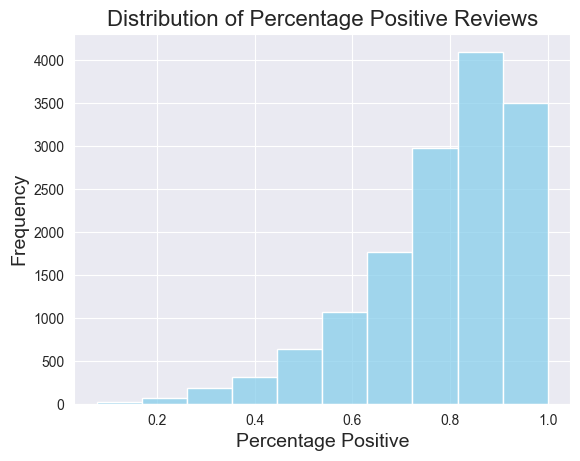

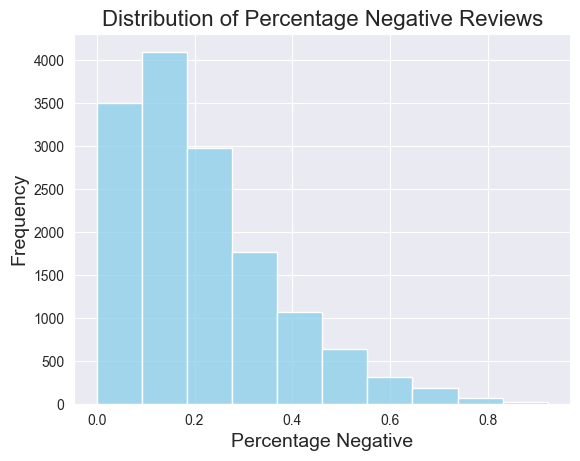

In [133]:
# Specify variables to plot for positive and negative reviews
variables = ["percentage_positive", "percentage_negative"]

# Histogram for Percentage Positive and Negative Reviews
for var in variables:
    sns.histplot(games_df[var], bins=10, color='skyblue')
    if var == 'percentage_positive':
        plt.title("Distribution of Percentage Positive Reviews", fontsize=16)
    else:
        plt.title("Distribution of Percentage Negative Reviews", fontsize=16)

    if var == 'percentage_positive':
        plt.xlabel("Percentage Positive", fontsize=14)
    else:
        plt.xlabel("Percentage Negative", fontsize=14)

    plt.ylabel("Frequency", fontsize=14)
    plt.grid(True)
    plt.show()

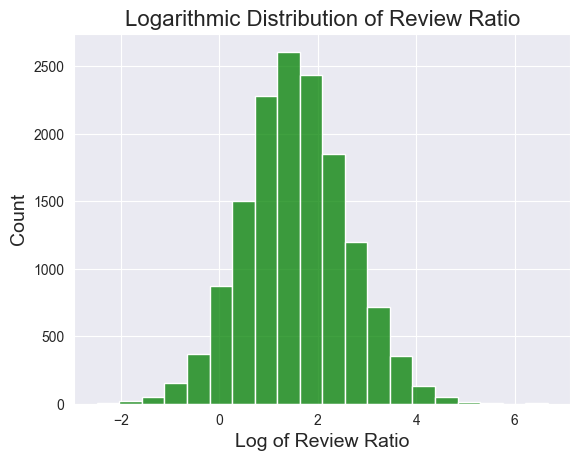

In [147]:
# Histogram for Log of Review Ratio
sns.histplot(np.log(games_df["review_ratio"]), bins=20, color='green')
plt.title("Logarithmic Distribution of Review Ratio", fontsize=16)
plt.xlabel("Log of Review Ratio", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.grid(True)
plt.show()

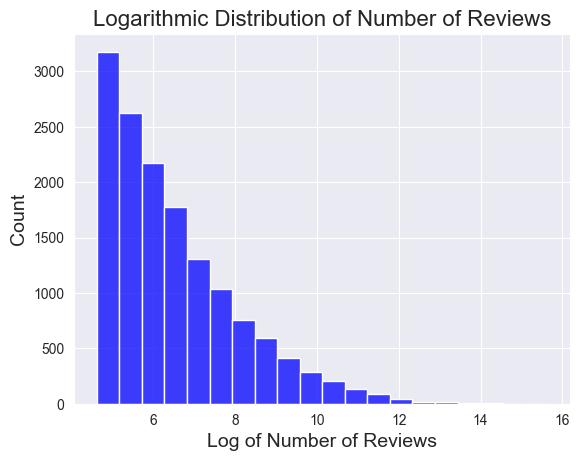

In [146]:
# Histogram for Log of Number of Reviews
sns.histplot(np.log(games_df["n_reviews"]), bins=20, color='blue')
plt.title("Logarithmic Distribution of Number of Reviews", fontsize=16)
plt.xlabel("Log of Number of Reviews", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.grid(True)
plt.show()

Lets see how the percent positive correlates with the positive sentiment analysis score

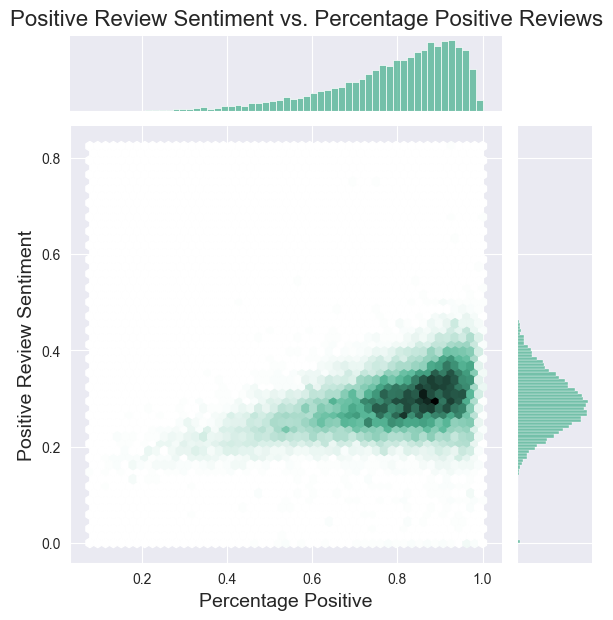

In [144]:
# Hexbin plot for Positive Review Sentiment vs. Percentage Positive Reviews
sns.jointplot(
    x="percentage_positive",
    y="pos_sent",
    data=games_df,
    kind="hex",
    color="#4CB391",
)
plt.suptitle("Positive Review Sentiment vs. Percentage Positive Reviews", fontsize=16, y=1.02)
plt.xlabel("Percentage Positive", fontsize=14)
plt.ylabel("Positive Review Sentiment", fontsize=14)
plt.show()

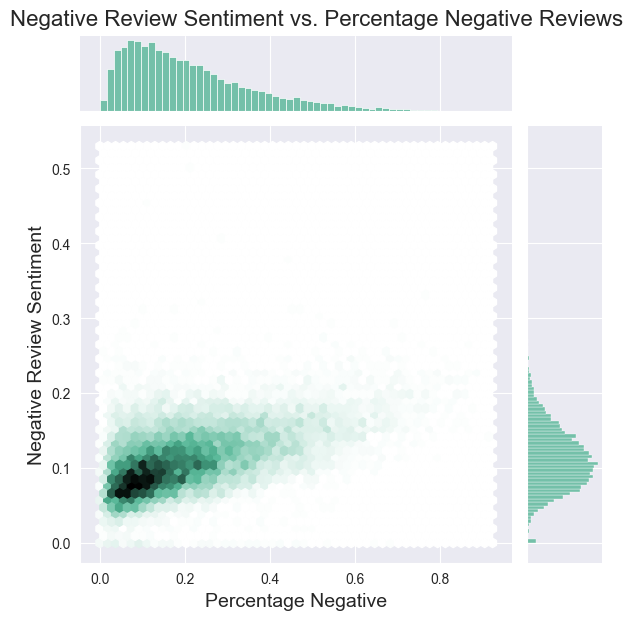

In [145]:
# Hexbin plot for Negative Review Sentiment vs. Percentage Negative Reviews
sns.jointplot(
    x="percentage_negative",
    y="neg_sent",
    data=games_df,
    kind="hex",
    color="#4CB391",
)
plt.suptitle("Negative Review Sentiment vs. Percentage Negative Reviews", fontsize=16, y=1.02)
plt.xlabel("Percentage Negative", fontsize=14)
plt.ylabel("Negative Review Sentiment", fontsize=14)
plt.show()

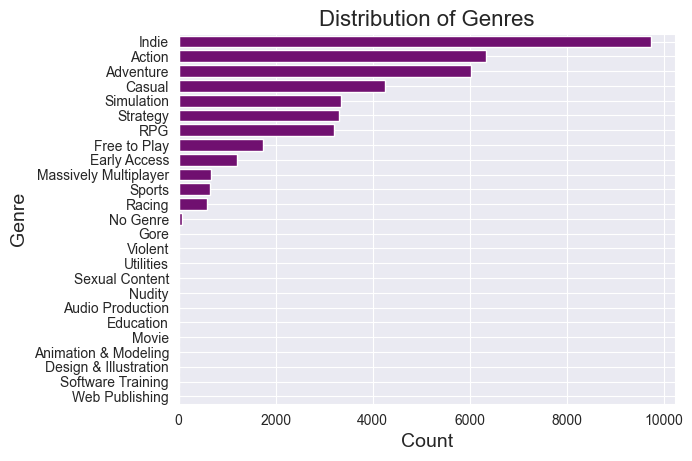

In [150]:
# Splitting the 'genre' column and expanding it into separate rows
genre_expanded = games_df['genre'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
genre_counts = genre_expanded.value_counts()

# Plotting the distribution of genres
sns.barplot(x=genre_counts, y=genre_counts.index, color='purple')
plt.title("Distribution of Genres", fontsize=16)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Genre", fontsize=14)
plt.grid(True)
plt.show()

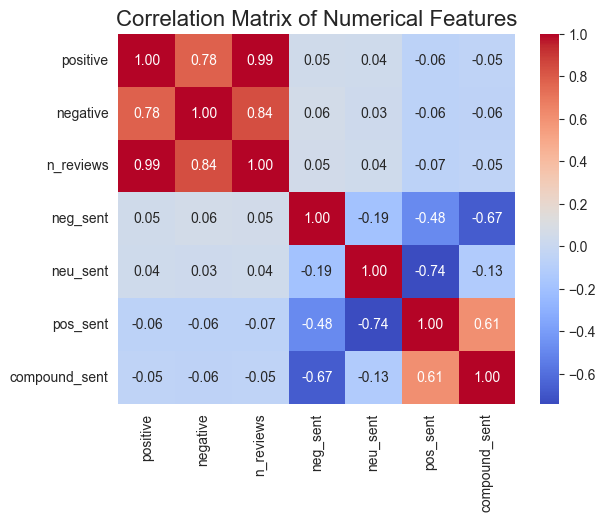

In [151]:
# Selecting numerical columns for correlation
numerical_cols = ['positive', 'negative', 'n_reviews', 'neg_sent', 'neu_sent', 'pos_sent', 'compound_sent']
correlation_matrix = games_df[numerical_cols].corr()

# Plotting the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Features", fontsize=16)
plt.show()

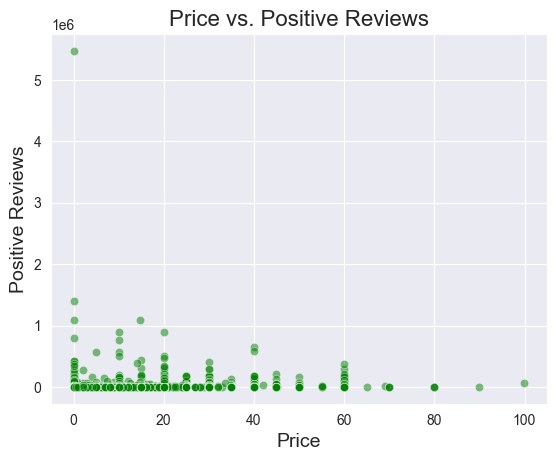

In [167]:
# Scatter plot of price vs. positive reviews
sns.scatterplot(x=games_df['price'] / 100, y='positive', data=games_df, color='green', alpha=0.5)
plt.title("Price vs. Positive Reviews", fontsize=16)
plt.xlabel("Price", fontsize=14)
plt.ylabel("Positive Reviews", fontsize=14)
plt.grid(True)
plt.show()

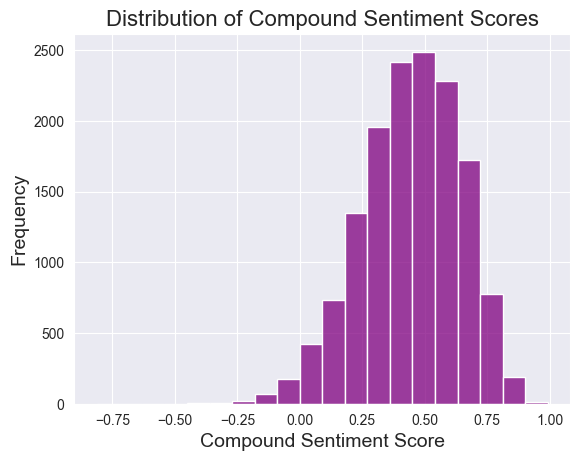

In [158]:
# Histogram of compound sentiment scores
sns.histplot(games_df['compound_sent'], bins=20, color='purple')
plt.title("Distribution of Compound Sentiment Scores", fontsize=16)
plt.xlabel("Compound Sentiment Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True)
plt.show()

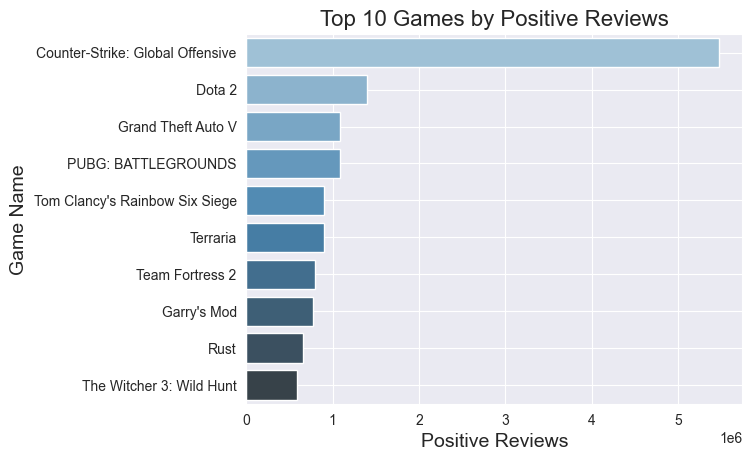

In [163]:
# Top 10 games by positive reviews
top_positive_games = games_df.nlargest(10, 'positive')

# Bar plot of top 10 games by positive reviews
sns.barplot(x='positive', y='name', data=top_positive_games, palette="Blues_d")
plt.title("Top 10 Games by Positive Reviews", fontsize=16)
plt.xlabel("Positive Reviews", fontsize=14)
plt.ylabel("Game Name", fontsize=14)
plt.grid(True)
plt.show()

In [46]:
#  Use statsmodels to Create a regression model for percentage positive reviews and positive sentiment
model = ols(
    "percentage_positive ~ pos_sent", data=games_df
).fit()  # Use ordinary least squares regression

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     percentage_positive   R-squared:                       0.177
Model:                             OLS   Adj. R-squared:                  0.177
Method:                  Least Squares   F-statistic:                     3144.
Date:                 Wed, 06 Dec 2023   Prob (F-statistic):               0.00
Time:                         15:22:10   Log-Likelihood:                 7952.2
No. Observations:                14636   AIC:                        -1.590e+04
Df Residuals:                    14634   BIC:                        -1.589e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4792      0.006     85.746      0.000       0.468       0.490
pos_sent       1.0525      0.019     56.073      0.000       1.016       1.089
==============================================================================
Omnibus:                     1115.401   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1454.614
Skew:                          -0.679   Prob(JB):                         0.00
Kurtosis:                       3.737   Cond. No.                         17.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
model = ols(
    "percentage_negative ~ neg_sent", data=games_df
).fit()  # Use ordinary least squares regression

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     percentage_negative   R-squared:                       0.251
Model:                             OLS   Adj. R-squared:                  0.251
Method:                  Least Squares   F-statistic:                     4903.
Date:                 Wed, 06 Dec 2023   Prob (F-statistic):               0.00
Time:                         15:22:35   Log-Likelihood:                 8642.6
No. Observations:                14636   AIC:                        -1.728e+04
Df Residuals:                    14634   BIC:                        -1.727e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0052      0.003      1.622      0.105      -0.001       0.011
neg_sent       1.8531      0.026     70.021      0.000       1.801       1.905
==============================================================================
Omnibus:                     1217.384   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1824.538
Skew:                           0.657   Prob(JB):                         0.00
Kurtosis:                       4.124   Cond. No.                         24.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Genre Encoding

### Analyzing Genre Distributions on Steam

To effectively analyze the distribution of game genres on Steam, we need to transform the `genre` column for better usability:
- **Current State**: The `genre` column presently consists of lists containing multiple genres per game.
- **Encoding Approach**:
  - We will first split these genre lists into separate entities.
  - Subsequently, we will create a new column for each distinct genre.
  - In these new columns, a game will be marked with '1' if it belongs to that genre, and '0' otherwise.

This encoding strategy will enable us to perform a detailed and structured analysis of genre distributions across the Steam games dataset.

In [208]:
# Selecting the 'appid', 'name', and 'genre' columns from the games_df DataFrame
genre_df = games_df[
    [
        "appid",
        "name",
        "genre",
    ]
]

mlb = MultiLabelBinarizer()

# Create a dataframe with the encoded genre column
genres = pd.DataFrame(
    mlb.fit_transform(games_df["genre"].astype(str).str.split(", ")),
    columns=mlb.classes_,
    index=games_df.index,
)

# Displaying the first few rows of the genres DataFrame 
genres.head()

,Action,Adventure,Animation & Modeling,Audio Production,Casual,Design & Illustration,Early Access,Education,Free to Play,Gore,...,Racing,Sexual Content,Simulation,Software Training,Sports,Strategy,Utilities,Violent,Web Publishing,nan
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### **Refining Genre Data**

- **Handling Rare Genres**: In our dataset, some genres are represented by only a small number of games.
- **Action Plan**: We will remove these less common genres from our dataset. This approach ensures our analysis concentrates on genres with sufficient data points.

In [49]:
# Filter out genres with less than 10 games
red_genres = genres[genres.columns[genres.sum() > 10]]

In [50]:
# Displaying the first few rows of new genres DataFrame with filtered genres
red_genres.head()

,Action,Adventure,Casual,Early Access,Free to Play,Indie,Massively Multiplayer,No Genre,RPG,Racing,Simulation,Sports,Strategy
0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0


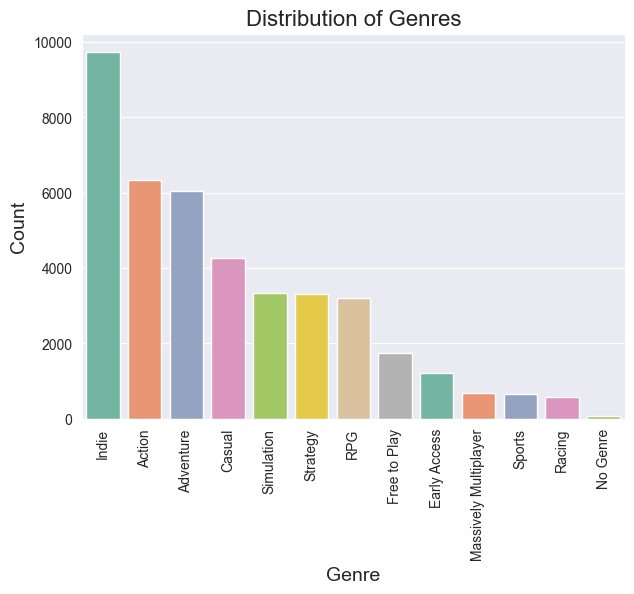

In [209]:
# Plotting the distribution of genres
plt.figure(figsize=(7, 5))
sns.barplot(
    x=red_genres.columns,
    y=red_genres.sum(),
    order=red_genres.sum().sort_values(ascending=False).index,
    palette="Set2",
)
plt.xticks(rotation=90)
plt.title("Distribution of Genres", fontsize=16)
plt.xlabel("Genre", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

### Language Encoding

#### **Optimizing the Language Data for Analysis**

- **Initial Plan for 'Language' Column**: Our original strategy, mirroring the approach taken with the 'genre' column, was to encode each language into a separate column.
- **Revised Approach Due to High Variability**:
  - Analysis revealed that some games list up to 29 different languages. Encoding each language separately would lead to the creation of 29 new columns.
  - To avoid the complexity and potential analytical challenges posed by such a high-dimensional dataset, we have revised our strategy.
- **New Strategy: Count of Languages**:
  - We will introduce a new column that indicates the total number of languages each game supports.
  - This approach simplifies the data while still allowing us to explore potential correlations between the language support and the number of positive reviews a game receives.

In [211]:
# Adding a new column 'n_languages' to 'games_df' to count the number of languages each game supports
games_df["n_languages"] = games_df["languages"].str.split(",").str.len()

# Sorting 'games_df' by the new 'n_languages' column in descending order
games_df.sort_values(by="n_languages", ascending=False).head()

,appid,name,developer,publisher,positive,negative,owners,average_forever,average_2weeks,median_forever,...,languages,genre,ccu,tags,neg_sent,neu_sent,pos_sent,compound_sent,n_reviews,n_languages
13162,1285000,Stayhome Simulator,Two Inc,Click Games,100,30,"20,000 .. 50,000",0,0,0,...,"English, French, Italian, German, Spanish - Sp...","Action, Adventure, Casual, Indie, Simulation, ...",0,"{'Casual': 119, 'Indie': 118, 'Action': 116, '...",0.081627,0.603569,0.275569,0.259290,130,29
14313,1554790,Coloring Game 4,L. Stotch,L. Stotch,1236,77,"100,000 .. 200,000",118,0,171,...,"English, French, Italian, German, Spanish - Sp...","Casual, Free to Play, Indie",109,"{'Free to Play': 35, 'Indie': 34, 'Casual': 34...",0.060900,0.539490,0.389620,0.533057,1313,29
10666,939390,The Life of One Dog,BrainStorming Team,КиКо,46,60,"0 .. 20,000",0,0,0,...,"English, French, Italian, German, Spanish - Sp...",Casual,0,"{'Casual': 24, 'RPGMaker': 8}",0.211256,0.595721,0.169651,-0.121077,106,29
13230,1295790,The Longest Road on Earth,"Brainwash Gang, TLR Games",Raw Fury,215,32,"0 .. 20,000",0,0,0,...,"English, French, Italian, German, Spanish - Sp...","Adventure, Casual, Indie",0,"{'Adventure': 268, 'Casual': 258, 'Interactive...",0.068750,0.664610,0.266660,0.551253,247,29
11601,1064730,Fantasy Girl,Inverse Game,Inverse Game,4723,227,"100,000 .. 200,000",17,0,21,...,"English, French, Italian, German, Spanish - Sp...","Adventure, Casual, RPG, Simulation, Strategy",1,"{'Sexual Content': 122, 'Nudity': 101, 'Mature...",0.107160,0.610710,0.282090,0.335418,4950,29


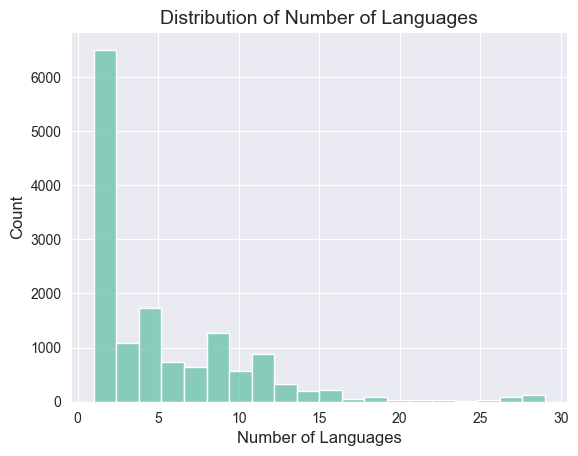

In [213]:
# Plotting the distribution of number of languages
sns.histplot(games_df["n_languages"], bins=20)
plt.title("Distribution of Number of Languages", fontsize=14)
plt.xlabel("Number of Languages", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(True)
plt.show()

**Insights from Language Distribution Graph**

- The distribution is **right-skewed**, meaning most games support fewer languages.
- A majority of the games support **1 to 5 languages**; this is the most common range.
- There are **peaks at 5 and 10 languages**, suggesting the standard threshold for language support.
- Games supporting over 25 languages are **outliers**.
- Overall, extensive language support is uncommon, with most games targeting specific language markets.

In [54]:
# Counting the occurrences of each unique language for games that only support one language.
games_df[games_df["n_languages"] == 1].value_counts("languages")

languages
English                5044
Simplified Chinese       36
Japanese                  5
Russian                   2
French                    1
Korean                    1
Thai                      1
Traditional Chinese       1
Name: count, dtype: int64

#### **Single Language Support Analysis**

The breakdown of single-language games is as follows:
- **English**: 5044
- **Simplified Chinese**: 36
- **Japanese**: 5
- **Russian**: 2
- **French**: 1
- **Korean**: 1
- **Thai**: 1
- **Traditional Chinese**: 1

Given this distribution, we observe that majority of single-language games are available in English. To accommodate this insight, we will create a binary variable in our dataset to indicate the presence of English language support for each game.


In [223]:
# Creating a new column 'english' to indicate whether a game supports English
games_df["english"] = games_df["languages"].astype(str).str.contains("English")
games_df["english"].value_counts()

english
True     14571
False       65
Name: count, dtype: int64

#### **Publisher and Developer Classification**

Given the broad range of publishers and developers in our dataset, our strategy is to categorize them based on their presence on Steam:
- **Major Publisher**: We'll define a 'major publisher' as one that has published over 50 games on Steam. A new column will be created to flag games associated with these major publishers.
- **Major Developer**: Similarly, a 'major developer' will be defined as one with more than 25 games on Steam. A corresponding column will mark games from these developers.

In [214]:
# Calculating the number of unique publishers
games_df["publisher"].value_counts().shape

(6924,)

In [219]:
# Identifying major publishers by counting number of games each publisher has in the dataset
maj_pub = games_df.value_counts("publisher")

# Filtering out publishers with less than 50 games
maj_pub = maj_pub[maj_pub > 50]

# Determining the number of major publishers
maj_pub.shape

(20,)

In [220]:
# Identifying major developers by counting number of games each developer has in the dataset
maj_dev = games_df.value_counts("developer")

# Filtering out developers with less than 25 games
maj_dev = maj_dev[maj_dev > 25]

# Determining the number of major developers
maj_dev.shape

(6,)

In [221]:
# Creating new columns to indicate whether a game was developed or published by a major developer or publisher
games_df["major_publisher"] = games_df["publisher"].isin(maj_pub.index)
games_df["major_developer"] = games_df["developer"].isin(maj_dev.index)

# Model  Building

## Feature Selection

In [224]:
# Select features and target
features = [
    "major_developer",
    "major_publisher",
    "developer",
    "publisher",
    "genre",
    "price",
    "n_languages",
    "english",
]  # Add 'categories' if available
X = games_df[features]
y = games_df["compound_sent"]

## Genre Encoding
Due to the potential for different number of genres to be in each section of our test/train split. We will encode the genres before the split.

## Regression Model for Predicting Consumer Sentiment

We aim to construct a regression model to predict the consumer sentiment for new games entering the market. The model will incorporate the following predictive features:
- `major_developer`: Indicating if the game is developed by a major developer.
- `major_publisher`: Indicating if the game is published by a major publisher.
- `developer`: The name of the developer.
- `publisher`: The name of the publisher.
- `genre`: The genre(s) of the game.
- `price`: The retail price of the game.
- `n_languages`: The number of languages the game supports.
- `english`: Whether the game supports English.

We plan to evaluate two versions of the model:
1. One predicting the **percentage of positive ratings** on Steam.
2. Another estimating the **composite sentiment score** from our sentiment analysis.

These features are specifically selected because they are known prior to a game's release and are independent of the game's subsequent popularity.

In [64]:
def genre_encoding(df):
    """
    Takes in a dataframe and returns a dataframe with the genre column encoded
    """
    # Create our multilabel Binarizer object
    mlb = MultiLabelBinarizer()

    # Create a dataframe with the encoded genre column
    genres = pd.DataFrame(
        mlb.fit_transform(df["genre"].astype(str).str.split(", ")),
        columns=mlb.classes_,
        index=df.index,
    )

    # Filter out genres with less than 10 games
    # red_genres = genres[genres.columns[genres.sum() > 10]]

    # Concatenate the original dataframe and the encoded genres
    df = pd.concat([df.drop("genre", axis=1), genres], axis=1)
    return df

In [65]:
# Prepare the data for modeling
X_prep = genre_encoding(X)

#### **Training and Testing Data Split**

To develop and validate our regression model, we will partition the data as follows:
- **Training Set**: 80% of the data will be allocated for training the model.
- **Testing Set**: The remaining 20% will be reserved for model testing.

A `random_state` of 42 will be applied to ensure consistency and reproducibility in our results across different runs.

In [66]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_prep, y, test_size=0.2, random_state=42
)

## Model Pipeline

#### **Data Preprocessing**

In the preprocessing phase, we will perform the following steps:

- **Scaling Numerical Variables**: We will scale numerical variables to ensure that they have similar scales, which is essential for some machine learning algorithms.

- **One-Hot Encoding Categorical Variables**: Categorical variables like 'developer' and 'publisher' will be one-hot encoded. This transformation converts categorical variables into a format that can be used for machine learning. 'genre' and 'languages' were previously encoded, thus no further encoding is needed for those columns.

These preprocessing steps will prepare the data for building and training our regression model.

In [225]:
# Preprocessing for numerical data (price and n_languages) and categorical data (developer, publisher, and genre)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ["price", "n_languages"]),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore"),
            ["publisher", "developer"],
        ),
    ]
)

In [226]:
# Preprocess the training and test data
X_train_prep = preprocessor.fit_transform(X_train) # Fit and transform the training data
X_test_prep = preprocessor.transform(X_test) # Transform the test data using same preprocessing

# Model Selection

We will begin by evaluating the performance of four different regression models:

- Linear Regression
- Random Forest Regressor
- Support Vector Regressor
- Voting Regressor (Ensemble of the above three models)

We will assess the performance of these models using the root mean square error (RMSE) as our evaluation metric. The model with the lowest RMSE will be considered the best fit for our task.

In [69]:
# Establish our regressors
reg1 = RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1)
reg2 = LinearRegression()
reg3 = SVR(kernel="rbf")

### Hyperparameter Tuning

In [227]:
# Hyperparameter tuning grid for each of the three models: RandomForestRegressor, LinearRegression, and SVR
param_grid = {
    "rf": {"n_estimators": [10, 20, 30], "max_depth": [None, 5, 10]},
    "svr": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf", "poly"]},
    "lr": {
        "fit_intercept": [True, False],
    },
}

In [228]:
# Create a dictionary of our models
models = {"rf": reg1, "lr": reg2, "svr": reg3}

best_params = {}
# Iterate through the dictionary of models
for name, model in models.items():

    # GridSearchCV for each model
    grid = GridSearchCV(model, param_grid[name], cv=5, n_jobs=-1, verbose=1)
    grid.fit(X_train_prep, y_train)

    # Save the best parameters and print them
    best_params[name] = grid.best_params_
    print(grid.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'max_depth': None, 'n_estimators': 30}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'fit_intercept': True}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'C': 1, 'kernel': 'rbf'}


In [232]:
# Set the hyperparameters of the Random Forest model to the best parameters found by GridSearchCV
reg1.set_params(**best_params["rf"])

# Set the hyperparameters of the Linear Regression model to the best parameters found by GridSearchCV
reg2.set_params(**best_params["lr"])

# Set the hyperparameters of the SVR model to the best parameters found by GridSearchCV
reg3.set_params(**best_params["svr"])

# Print regression model to ensure hyperparameters were set correctly
print(reg1)
print(reg2)
print(reg3)

RandomForestRegressor(n_estimators=30, n_jobs=-1, random_state=42)
LinearRegression()
SVR(C=1)


#### **Hyperparamter Tuning**

- The hyperparameters for each model will be tuned using GridSearchCV with 5-fold Cross Validation.
- The resulting optimal hyperparameters will be used to create a new model for our final predictions.
- This approach ensures that our models are fine-tuned and optimized for optimal predicitve performance.

### Random Forest Regressor

In [233]:
# Fit the Random Forest Regressor model to the training data
reg1.fit(X_train_prep, y_train)

# Make predictions on the test data
y_pred = reg1.predict(X_test_prep)

# Calculate and print the Mean Squared Error (MSE) as the evaluation metric
print(
    "Random Forest Regressor Mean Squared Error:",
    mean_squared_error(y_test, y_pred),
)

Random Forest Regressor Mean Squared Error: 0.03629024612331365


### Linear Regression

In [234]:
# Fit the Linear Regression model to the training data
reg2.fit(X_train_prep, y_train)

# Make predictions on the test data
y_pred = reg2.predict(X_test_prep)

# Calculate and print the Mean Squared Error (MSE) as the evaluation metric
print(
    "Linear Regression Mean Squared Error:", mean_squared_error(y_test, y_pred)
)

Linear Regression Mean Squared Error: 0.03865078467441476


### Support Vector Regressor

In [235]:
# Fit the SVR model to the training data
reg3.fit(X_train_prep, y_train)

# Make predictions on the test data
y_pred = reg3.predict(X_test_prep)

# Calculate and print the Mean Squared Error (MSE) as the evaluation metric
print("SVR Mean Squared Error:", mean_squared_error(y_test, y_pred))

SVR Mean Squared Error: 0.033486805254690916


**Insight**

- Random Forest Regressor Mean Squared Error: 0.036
- Linear Regression Mean Squared Error: 0.038
- Support Vector Regressor (SVR) Mean Squared Error: 0.033

A lower MSE suggests that the model's predicitons are more accurate and closer to the actual values. Among the three models tested, the Support Vector Regressor (SVR) performed the best in terms of MSE, indicating that it has the lowest prediction error on the test data.

#### **Voting Regressor**

Once we have determined our best hyperparameters, we will use a Voting Regressor to combine the results of our three models. This ensemble method will take advantage of the strengths of each individual model to make a collective prediction. It can often result in improved overall performance and more accurate prediction.

In [236]:
# Establish a voting regressor with the best parameters from each model
voting_reg = VotingRegressor(
    [("rf", reg1), ("lr", reg2), ("svr", reg3)], n_jobs=-1
)

In [237]:
# Creating a pipepline that includes data preprocessing and Voting Regressor
pipe4 = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("voting", voting_reg),
    ]
)

In [238]:
# Fit the pipeline to the training data
pipe4.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipe4.predict(X_test)

# Calculate and print the Mean Squared Error (MSE) as the evaluation metric
print(
    "Voting Regressor Mean Squared Error:", mean_squared_error(y_test, y_pred)
)

Voting Regressor Mean Squared Error: 0.032582549903375856


#### **Final Model Selection**

After evaluating each model, we have decided to proceed with the Voting Regressor as our final model for predicting consumer sentiment. The Voting Regressor leverages the results of our three models (Random Forest Regressor, Linear Regression, and Support Vector Regressor) to make predictions. Since the MSE value for Voting Regressor was 0.032, this ensemble approach offers a more accurate and dependable method for forecasting consumer sentiment for new games entering the marketplace.


## Final Model Predictions

In [239]:
# Fit the Voting Regressor model on the preprocessed training data
voting_reg.fit(X_train_prep, y_train)

# Make predictions on the test data
y_pred = voting_reg.predict(X_test_prep)

# Calculate and print the Mean Squared Error (MSE) as the evaluation metric
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

Mean Squared Error: 0.032582549903375856


---